# [View this notebook in nbviewer](https://nbviewer.org/github/yardimcilab/wistan/blob/main/demo-after.ipynb)

# Anatomy of a Wistan pipeline: motivation
For mass adoption, you should probably **make a tailored command-line interface for your pipeline.** This should expose **only** the
parameters the user might actually want to tweak during normal use, supplying sensible defaults and descriptions of what they do.

Here, we're going to look at the building blocks of the first pipeline built with Wistan. The pipeline will look more complicated, but 
this is just like taking the casing off your computer. If you want to build a computer, look at the hardware on the inside to see how it works.
If you want to sell a computer, put it in a nice case. Analogously, wrap your pipeline in a nice

It originates in the bioinformatics field of the study of chromatin conformation. The author was using a tool called [hicrep](https://github.com/dejunlin/hicrep)
to compute sample-vs-sample reproducibility scores for a large number of data files. The challenge was that `hicrep` only allows one to to
run a single sample-vs-sample comparison. Its output is a plaintext series of comments and per-chromosome reproducibility scores in a text file.

The author wanted to batch `hicrep` comparisons on a large number of data files, compute the mean of the per-chromosome scores for each comparison,
and produce a [clustermap](https://seaborn.pydata.org/generated/seaborn.clustermap.html) with row and column captions being the data file prefixes.
Having a whole PhD in this subfield ahead of him, the author wanted a tool to make this conveniently in the future.


# Initialize sanb
Initialize sanb with the name of the notebook. This makes allows the pipeline to append its own outputs to this notebook.

In [1]:
import sanb
sanb.set_notebook("demo-after.ipynb")

# Download data
Download data to be analyzed (390M).

In [ ]:
!mkdir -p ~/data
!wget -P ~/data/ https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4604nnn/GSM4604290/suppl/GSM4604290%5F990.iced.mcool
!wget -P ~/data/ https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4604nnn/GSM4604276/suppl/GSM4604276%5F868.iced.mcool
!wget -P ~/data/ https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM4604nnn/GSM4604278/suppl/GSM4604278%5F1953.iced.mcool

# Install package and write analysis plugin script
Install the [hicrep](https://github.com/dejunlin/hicrep) package, the cornerstone of our analysis.

A single, small, specialized plugin transforms raw text from the hicrep analysis tool into the mean value we are interested in.

It simply reads `stdin`, extracts any lines containing floating-point numbers, and prints their average to `stdout`.

For easy sharing, we store the plugin in the Jupyter notebook itself and write it to a file for use in the main pipeline.

Note that setting permissions is important!

Yang, T., Zhang, F., Yardımcı, G. G., Song, F., Hardison, R. C., Noble, W. S., ... & Li, Q. (2017). HiCRep: assessing the reproducibility of Hi-C data using a stratum-adjusted correlation coefficient. Genome research, 27(11), 1939-1949.

In [12]:
!pip install hicrep > /dev/null
hicrep_mean=r'''#!/usr/bin/env python3
import sys, statistics, click

hicrep_output = sys.stdin.read().split(\"\\n\")

scc_scores = []
for line in hicrep_output:
    try:
        scc_scores.append(float(line))
    except ValueError:
        continue
click.echo(statistics.mean(scc_scores))'''
!mkdir -p ~/scripts && echo "$hicrep_mean" > ~/scripts/hicrep_mean
!chmod +x ~/scripts/hicrep_mean

# Main pipeline
We will examine this line by line. Note that for distribution, this is far too complicated an interface. We can easily develop a sleek command-line based interface for it, however. This would expose just the parameters of the pipeline that the user may wish to modify, such as the arguments to `hicrep` or the location of the data.

In [ ]:
sanb.last = "samb_cell0"; sanb.lidx = sanb.lastidx()
!mkdir -p scc
!ls ~/data/*.mcool | itertools-cli combinations-with-replacement 2 | curry-batch "echo {{1}}" "echo {{2}}" "pathlib-cli prefix {{1}}" "pathlib-cli prefix {{2}}" > hicrep_inputs.txt
!cat hicrep_inputs.txt | curry-batch "hicrep {{1}} {{2}} scc/{{3}}_{{4}}.txt --h 1 --binSize 1000000 --dBPMax 5000000" > /dev/null && cat hicrep_inputs.txt | curry-batch "echo {{3}}" "echo {{4}}" "cat scc/{{3}}_{{4}}.txt" > hicrep_results.txt
!cat hicrep_results.txt | curry-batch "echo {{1}}" "echo {{2}}" "echo '{{3}}' | ~/scripts/hicrep_mean" | curry-batch "echo {{1}}" "echo {{2}}" "echo {{3}}" "echo {{2}}" "echo {{1}}" "echo {{3}}" | pandas-cli dataframe "df = pd.DataFrame(df.values.reshape(2*df.shape[0], 3)).drop_duplicates().pivot(index=0, columns=1, values=2).apply(pd.to_numeric)" > hicrep_data.yaml
!datavis-cli load-dataframe hicrep_data.yaml df | nbformat-cli cell add {sanb.notebook} {sanb.lidx} --distance 1
!datavis-cli clustermap df | nbformat-cli cell add {sanb.notebook} {sanb.lidx} --distance 2

In [27]:

import pandas as pd
import yaml

with open("hicrep_data.yaml", 'r') as file:
    df = pd.DataFrame(yaml.safe_load(file))
print(df.head())
print(df.describe())



                 GSM4604276_868  GSM4604278_1953  GSM4604290_990
GSM4604276_868         1.000000         0.865908        0.898248
GSM4604278_1953        0.865908         1.000000        0.904402
GSM4604290_990         0.898248         0.904402        1.000000
       GSM4604276_868  GSM4604278_1953  GSM4604290_990
count        3.000000         3.000000        3.000000
mean         0.921385         0.923436        0.934217
std          0.069976         0.069043        0.057053
min          0.865908         0.865908        0.898248
25%          0.882078         0.885155        0.901325
50%          0.898248         0.904402        0.904402
75%          0.949124         0.952201        0.952201
max          1.000000         1.000000        1.000000


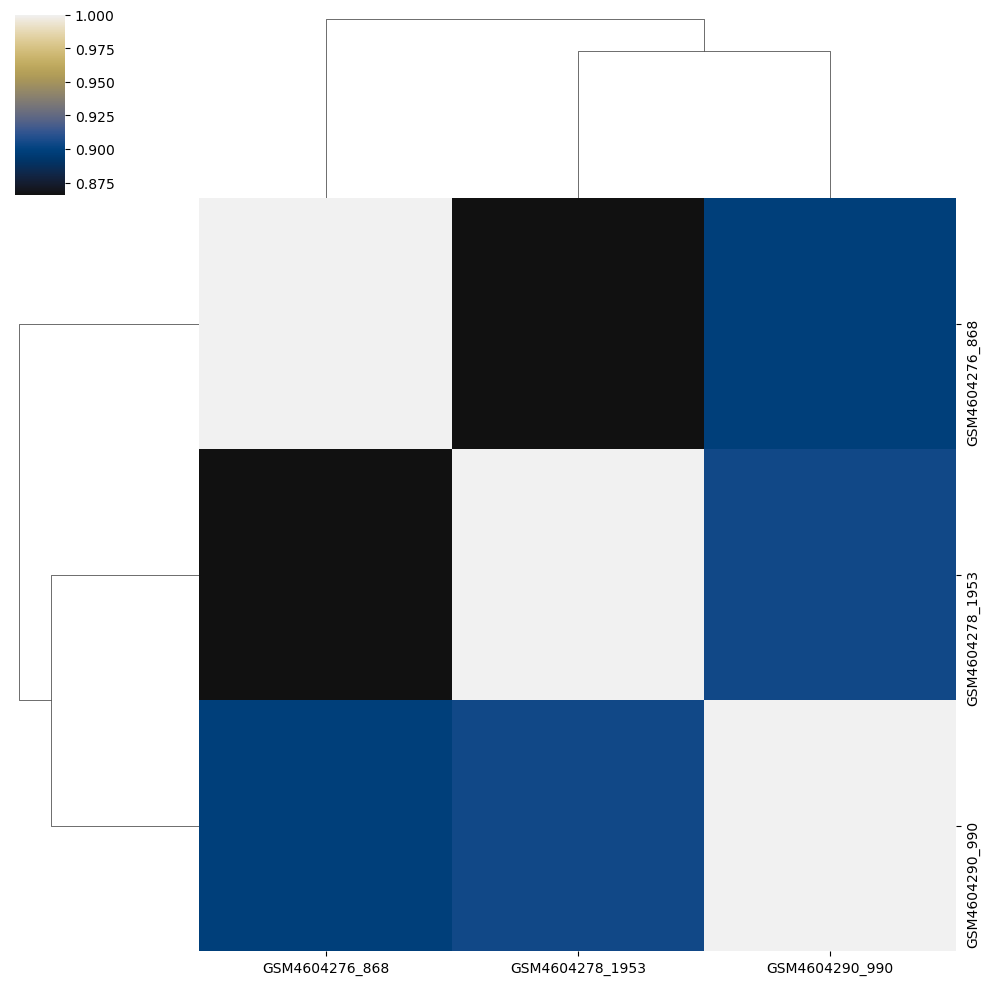

In [28]:

import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc

# Default colormap is perceptually-accurate and colorblind-friendly
# See https://colorcet.com/index.html for details
# Seaborn clustermap documentation
# https://seaborn.pydata.org/generated/seaborn.clustermap.html
sns.clustermap(df, 
               pivot_kws=None, 
               method='average', 
               metric='euclidean', 
               z_score=None, 
               standard_scale=None, 
               figsize=(10, 10), 
               cbar_kws=None, 
               row_cluster=True, 
               col_cluster=True, 
               row_linkage=None, 
               col_linkage=None, 
               row_colors=None, 
               col_colors=None, 
               mask=None, 
               dendrogram_ratio=0.2, 
               colors_ratio=0.03, 
               cbar_pos=(0.02, 0.8, 0.05, 0.18), 
               tree_kws=None, 
               cmap=cc.cm.CET_CBL1)



## Line 1
```
sanb.last = "samb_cell0"; sanb.lidx = sanb.lastidx()
```
This gives the cell a unique ID, stored in the variable `sanb.last`. The `sanb.lastidx()` function looks up in this notebook the index
of a cell containing the phrase `sanb.last = [value of sanb.last]`. This retrieves the index of the current cell.

## Line 2
```
!mkdir -p scc
```
We create a folder to store the 289 intermediateper-comparison output files our analysis tool will generate for a 17-sample cross-comparison.

## Line 3
```
!ls ~/data/*.mcool | itertools-cli combinations-with-replacement 2 | curry-batch "echo {{1}}" "echo {{2}}" "pathlib-cli prefix {{1}}" "pathlib-cli prefix {{2}}" > hicrep_inputs.txt
```
The data to be compared has a file extension `.mcool`. We load all the filenames to be compared, then generate combinations with replacement.
We then extend this to a list of four strings: the two filenames, plus the filename prefixes that we wish to use.
We store this combination in `hicrep_inputs.txt` using a redirect for convenience and as a record of our output so far.

## Line 4
```
!cat hicrep_inputs.txt | curry-batch "hicrep {{1}} {{2}} scc/{{3}}_{{4}}.txt --h 1 --binSize 1000000 --dBPMax 5000000" > /dev/null && cat hicrep_inputs.txt | curry-batch "echo {{3}}" "echo {{4}}" "cat scc/{{3}}_{{4}}.txt" > hicrep_results.txt
```
We load the list of filenames and prefixes. Note that this is not strictly necessary - we could have just piped the output from the previous line into this one.
Next, we call the main `hicrep` command to compute reproducibility scores on all pairs of input files. For each list of `file1 file2 prefix1 prefix2` strings in the input:
 - `{{1}}` and `{{2}}` are replaced by `file1` and `file2`, and represent the input files.
 - `{{3}}` and `{{4}}` are replaced by `prefix1` and `prefix2`. `scc/{{3}}_{{4}}.txt` will be the location of the output file.
We silence the message outputs from hicrep by redirecting them to `/dev/null`. The `hicrep` program saves its outputs to individual text files, so we need to retrieve them.
We do this by once again piping our comparison filenames and prefixes and using `curry-batch` to load the raw output file contents using `cat`.
Again, we save this output to `hicrep_results.txt` as a record of our work so far and for convenience, but this isn't strictly necessary.

## Line 5
```
!cat hicrep_results.txt | curry-batch "echo {{1}}" "echo {{2}}" "echo '{{3}}' | ~/scripts/hicrep_mean" | curry-batch "echo {{1}}" "echo {{2}}" "echo {{3}}" "echo {{2}}" "echo {{1}}" "echo {{3}}" | pandas-cli dataframe "df = pd.DataFrame(df.values.reshape(2*df.shape[0], 3)).drop_duplicates().pivot(index=0, columns=1, values=2).apply(pd.to_numeric)" > hicrep_data.yaml
```
We use `curry-batch` to feed in our previous results into a custom Python script `hicrep_mean` tailor-made for this step, while preserving the filename prefixes for later captioning.
We then use `curry-batch` to duplicate the result with the order reversed, so that we can conveniently produce a symmetric matrix. This gives us a six-element `col_m row_n value col_n row_m value` list.
We then load this into a pandas dataframe and reshape it to get the desired square, symmetric matrix labeled with our captions. First, we append it to a `2nx3` matrix, with row caption, column caption,
and value columns. As the main diagonal is duplicated, we drop duplicates. Then we create a pivot dataframe to get it into the desired square shape and convert the values to numeric. Finally, we save this
to a data file `hicrep_data.yaml` for convenience.

## Line 6
```
!datavis-cli load-dataframe hicrep_data.yaml df | nbformat-cli cell add {sanb.notebook} {sanb.lidx} --distance 1
```
Our computations are done, and all that remains is to create a figure in the interactive environment of our Jupyter notebook for easy tweaking.
This function starts by leveraging the `sanb` package to add a new cell to the notebook immediately after the pipeline-running cell containing code
to load our output data into a pandas DataFrame called `df`.

## Line 7
```
!datavis-cli clustermap df | nbformat-cli cell add {sanb.notebook} {sanb.lidx} --distance 2
```
Finally, we add another cell immediately after the data-loading function that contains the function call
to produce a Seaborn clustermap from our data. The arguments to that function are comprehensively and explicitly
initialized to default values, and a link to the Seaborn clustermap API is printed for reference. The clustermap
uses a perceptually-accurate, colorblind-friendly colormap from [colorcet](https://colorcet.com/download/index.html) by default. These parameters
can be tweaked in the cell and the clustermap immediately reproduced.

## Reload from Disk
After these cells are produced by the pipeline cell, the notebook will need to be reloaded using `File/Reload Notebook From Disk`.

![image](https://github.com/yardimcilab/wistan/assets/86805107/4a9afd91-d88b-4966-851d-d2d260068ea9)

When run, the above cell adds two new cells (which will appear before this one).
 - A dynamically-generated data loader. This merely loads our output data from the main pipeline to a pandas DataFrame `df` and prints some summary statistics.
 - This is pipeline-generated boilerplate code to make a Seaborn clustermap displaying our results, which are now stored in `df`. We can modify the parameters to tweak the clustermap visualization.
 

# Conclusion
As you can see, outside the tiny analysis-specific `hicrep_mean` plugin script, all components of this pipeline are simple reusable parts.
Although this pipeline is unwieldly in the exposed form presented here, it can be easily wrapped into a more convenient command line interface
exposing just the variables the user needs to set. We provide it here as an example of how to build a useful Wistan pipeline.